In [20]:
import torch.nn as nn
import torch
import pandas as pd

In [2]:
class NeuralNetwork(nn.Module):
    """
    Neural Network Class for implementing neural networks for different loss and optimization functions.
    
    Attributes:
        input_size: An integer indicating number of input features.
        output_size: An integer indicating size of output.
        hidden_layer_size: An integer indicating size of hidden layer.
        
        w1: A vector (input_size X hidden_layers_sizes[0]) of floats required for training the neural network.
        wn: A vector (hidden_layers_sizes[-1] X output_size) for weights of final layer.
        
        activations: An array of strings indicating the activation functions for every layer.
        loss: A string indicating the loss function for the neural network.
        optimizer: A string indicating the optimization algorithm to be used to train the network.
    """
    def __init__(self, input_size, output_size, hidden_layer_size, activations, loss, optimizer):
        """
        Initializes Neural Network class attributes.
        
        Args:
            input_size (int): Number of features of the input.
            output_size (int): Dimension of output.
            hidden_layer_size (int): Number of neurons in the input layer.
            activations (list): List of strings giving the activations for each layer.
            loss (str): Loss function for the model.
            optimizer (str): Optimization algorithm for the model.
        """
        super(NeuralNetwork, self)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
        self.activations = activations
        self.loss = loss
        self.optimizer = optimizer
    
    
    def forward(self, X, w1=None, wn=None):
        """
        Forward pass of the neural network.
        
        Args:
            X (tensor): Input for the model. 
            w1 (tensor): Weights to be used for the first layer. (Optional Argument)
            wn (tensor): Weights to be used for the final layer. (Optional Argument)
            
        Returns:
            z (list): List of outputs from linear function at each layer.
            a (list): List of activation outputs from each layer.
        """
        if w1 is None:
            w1 = self.w1
        if wn is None:
            wn = self.wn
        z = []
        a = []
        z.append(torch.matmul(X, w1))
        a.append(self.evaluateActivation(self.activations[0])(z[-1]))
        z.append(torch.matmul(a[-1], wn))
        a.append(self.evaluateActivation(self.activations[1])(z[-1]))
        return z, a
    
    
    def backward(self, X, y, z, a, wn=None):
        """
        Backward Pass of the model.
        
        Args:
            X (Tensor): Input Data
            y (Tensor): Output Data
            z (list): List of outputs from linear layers.
            a (list): List of actiation outputs.
            wn (Tensor): Weights from final layer. (Optional Argument)
        """
        if wn is None:
            wn = self.wn
        dW = []
        dL_da_n = self.evaluateLossDerivative()(a[-1], y)
        da_n_dz_n = self.evaluateActivationDerivative(self.activations[1])(z[-1])
        dz_n_dWn = a[0]
        dL_dWn = torch.matmul(dz_n_dWn.T, (dL_da_n * da_n_dz_n))
        
        dz_n_da_1 = wn
        da_1_dz_1 = self.evaluateActivationDerivative(self.activations[0])(z[0])
        dz_1_dW1 = X
        dL_dW1 = torch.matmul(dz_1_dW1.T, (torch.matmul(dL_da_n * da_n_dz_n, dz_n_da_1.T)*da_1_dz_1))
        dW.append(dL_dW1)
        dW.append(dL_dWn)
        return dW
    
    
    def train(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False, decay_rate=0.999, beta1=0.9, beta2=0.999):
        """
        Function to train the neural network.
        """
        funVals = []
        ypred = None
        if self.optimizer == 'SGD':
            if momentum_param != 0:
                if nesterov:
                    funVals ,ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param, True)
                else:
                    funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param)
            else:
                funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'Adagrad':
            funVals, ypred = self.Adagrad(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'RMSProp':
            funVals, ypred = self.RMSProp(X, y, batch_size, iterations, alpha, decay_rate)
        elif self.optimizer == 'Adam':
            funVals, ypred = self.Adam(X, y, batch_size, iterations, alpha, beta1, beta2)
        return funVals, ypred
    
    
    def SGD(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False):
        """
        Gradient Descent Algorithm
        """
        m, n = X.shape
        funVals = []
        ypred = []
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        vn = torch.zeros(self.wn.shape, dtype=torch.double)
        n_iter = 0
        flag = True
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                if nesterov:
                    z, a = self.forward(X[i:i+batch_size], self.w1+momentum_param*v1, self.wn+momentum_param*vn)
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a, self.wn+momentum_param*vn)
                else:
                    z, a = self.forward(X[i:i+batch_size])
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                v1 = momentum_param * v1 - alpha * dW[0]
                vn = momentum_param * vn - alpha * dW[1]
                self.w1 = self.w1 + v1
                self.wn = self.wn + vn
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adagrad(self, X, y, batch_size=100, iterations=500, alpha=1e-5):
        """
        AdaGrad Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 += dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1)+smoothing_param)) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2)+smoothing_param)) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def RMSProp(self, X, y, batch_size=100, iterations=500, alpha=1e-04, decay_rate=0.999):
        """
        RMSProp Optimizer.
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 = decay_rate*cache1 + (1 - decay_rate) * dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1+smoothing_param))) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2+smoothing_param))) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adam(self, X, y, batch_size=100, iterations=500, alpha=1e-04, beta1=0.9, beta2=0.999):
        """
        Adam Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        m1 = torch.zeros(self.w1.shape, dtype=torch.double)
        m2 = torch.zeros(self.wn.shape, dtype=torch.double)
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        v2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                m1 = beta1 * m1 + (1-beta1) * dW[0]
                v1 = beta2 * v1 + (1-beta2) * dW[0]**2
                m2 = beta1 * m2 + (1-beta1) * dW[1]
                v2 = beta2 * v2 + (1-beta2) * dW[1]**2
                self.w1 += -alpha*(m1/(1-beta1**n_iter))/(torch.sqrt((v1)/(1-beta2**n_iter)) + smoothing_param)
                self.wn += -alpha*(m2/(1-beta1**n_iter))/(torch.sqrt((v2)/(1-beta2**n_iter)) + smoothing_param)
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
#             print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def predict(self, X):
        """
        Predict function
        """
        _, a = self.forward(X)
        return a[-1]
    
    
    def reset_weights(self):
        """
        Reset Weights
        """
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
    
    def evaluateActivation(self, activation):
        """
        Activation function
        """
        if activation == 'sigmoid' :
            def sigmoid(z):
                s = torch.exp(z)
                return s/(1+s)
            return sigmoid
#             return lambda z : torch.exp(z)/(1 + torch.exp(z))
        elif activation == 'relu':
            def relu(z):
                z1 = torch.clone(z)
                return z1.clamp(min=0)
            return relu
        elif activation == 'tanh':
            return lambda z : (2/(1+torch.exp(-2*z))) - 1
        return lambda z : z
    
    
    def evaluateActivationDerivative(self, activation):
        """
        Derivative of Activation Function
        """
        if activation == 'sigmoid':
            sigmoid = lambda z : torch.exp(z)/(1 + torch.exp(z))
            return lambda z : sigmoid(z) * (1 - sigmoid(z))
        elif activation == 'relu':
            def relu_derivative(z):
                z1 = torch.clone(z)
                z1[z>=0] = 1
                z1[z<0] = 0
                return z1
            return relu_derivative
        elif activation == 'tanh':
            tanh = lambda z : (2/(1+torch.exp(-2*z))) - 1
            return lambda z : 1 - tanh(z)**2
        return lambda z : 1
    
    
    def evaluateLoss(self):
        """
        Loss Function
        """
        if self.loss == 'MSE':
            return lambda ypred, y : torch.matmul((ypred - y).T, (ypred - y))/(2*len(y))
        elif self.loss == 'BCELoss':
            def binaryCrossEntropyLoss(ypred, y):
                ypredy1 = ypred[y==1]
                ypredy1[ypredy1==0] = 1
                loss = torch.sum(torch.log(ypred[y==1]+1e-05)) + torch.sum(torch.log(1 - ypred[y==0]+1e-05))
                return -loss/y.shape[0]
            return binaryCrossEntropyLoss
#             return lambda ypred, y : (-1/len(y))*(torch.matmul(y.T, torch.log(ypred)) + torch.matmul((1-y).T, torch.log(1-ypred)))
            return binaryCrossEntropyLoss
        elif self.loss == "CELoss":
            def crossEntropyLoss(ypred, y):
                m = y.shape[0]
                prob = self.softmax(ypred)
                log_likelihood = -torch.log(prob[range(m), y.long()])
                loss = torch.sum(log_likelihood)
                return loss/m
            return crossEntropyLoss
        return lambda x : 1
    
    
    def evaluateLossDerivative(self):
        """
        Loss function Derivative
        """
        if self.loss == 'MSE':
            return lambda ypred, y: (ypred - y)/len(y)
        elif self.loss == 'BCELoss':
            def binaryCrossEntropyLossGradient(ypred, y):
                gradient = 1/(ypred+1e-05) - 1/(1-ypred+1e-05)
                return -gradient/y.shape[0]
            return binaryCrossEntropyLossGradient
#             return lambda ypred, y: (-1/len(y)) * ((y/ypred) - ((1-y)/(1-ypred)))
        elif self.loss == 'CELoss':
            def crossEntropyLossGradient(ypred, y):
                m = y.shape[0]
                grad = self.softmax(ypred)
                grad[range(m), y.long()] -= 1
                return grad/m
            return crossEntropyLossGradient
        return lambda x : 1
    
    
    def softmax(self, z):
        exps = torch.exp(z - (torch.max(z, dim=1).values.reshape(-1,1)))
        return exps/torch.sum(exps, dim=1).reshape(-1, 1)

In [3]:
# X = torch.rand(312, 20, dtype=torch.double)
# # y = torch.randint(0, 2,(1000, 1)).double()
# # y = torch.randn(312, 1, dtype=torch.double)
# y = torch.randint(0,3,(312, 1)).double()

In [4]:
# model = NeuralNetwork(X.shape[1], 3, 32, ['tanh', 'linear'], 'CELoss', 'SGD')

In [5]:
# funVals, ypred = model.train(X, y, batch_size=100, iterations=1500, alpha=1e-03, momentum_param=0.9, nesterov=True)

In [6]:
# print((torch.sum(ypred.argmax(dim=1).reshape(-1,1) == y.long()).float()*100.0)/(y.shape[0]))

In [7]:
# %matplotlib inline
# # def plotLoss(funVals, filePath, title):
# import matplotlib.pyplot as plt
# plt.plot([i for i in range(1, len(funVals)+1)], funVals)
# plt.xlabel("Number of Iterations")
# plt.ylabel("Loss")

In [8]:
%matplotlib inline
def plotLoss(funVals, filePath, title, plot=False):
    import matplotlib.pyplot as plt
#     plt.xkcd()
    plt.plot([i for i in range(1, len(funVals)+1)], funVals)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    if plot:
        plt.show()
    else:
        plt.savefig("./dataset/"+filePath)

In [ ]:
## Regression

In [38]:
def loadAutoMPGDataset():
    import pandas as pd
    auto_mpg_dataset = pd.read_csv("./dataset/auto-mpg/auto-mpg.data", header=-1, comment='\t', skipinitialspace=True, na_values='?', sep=' ')
    auto_mpg_dataset = auto_mpg_dataset.dropna()
    origin = auto_mpg_dataset.pop(7)
    auto_mpg_dataset[7] = (origin==1)*1.0
    auto_mpg_dataset[8] = (origin==2)*1.0
    auto_mpg_dataset[9] = (origin==3)*1.0
    auto_dataset = torch.tensor(auto_mpg_dataset.values, dtype=torch.double)
    return auto_dataset

In [57]:
auto_dataset = loadAutoMPGDataset()
auto_dataset = auto_dataset[torch.randperm(auto_dataset.shape[0])]

In [58]:
train = auto_dataset[:int(0.8 * auto_dataset.shape[0])]
test = auto_dataset[int(0.8 * auto_dataset.shape[0]):]

Xtrain = train[:, 1:]
Xtrain = (Xtrain - Xtrain.mean(dim=0))/Xtrain.std(dim=0)
ytrain = train[:, 0].reshape(-1, 1)

Xtest = test[:, 1:]
Xtest = (Xtest - Xtest.mean(dim=0))/Xtest.std(dim=0)
ytest = test[:, 0].reshape(-1, 1)

In [59]:
auto_mpg_model = NeuralNetwork(Xtrain.shape[1], ytrain.shape[1], 64, ['relu', 'relu'], 'MSE', 'RMSProp')

In [60]:
auto_mpg_model.reset_weights()

In [61]:
funVals, ypred = auto_mpg_model.train(Xtrain, ytrain, batch_size=100, iterations=1000, alpha=1e-03)

100 18.377537658182767
200 10.65629269932579
300 8.330532623642775
400 7.26995060091635
500 6.663414803793913
600 6.28153355940342
700 6.021717846632825
800 5.796813981890418
900 5.632449464598464
1000 5.492211671672166


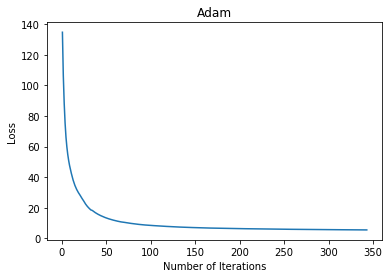

In [62]:
plotLoss(funVals, filePath="auto-mpg/results/Adam.png", title="Adam", plot=True)

In [68]:
optims=['SGD','SGDNesterov','Adagrad','RMSProp','Adam']
# optims=['RMSProp']
lrs=[1e-1,1e-2,1e-3,1e-4,1e-5]
activs=['sigmoid','relu','tanh']
losses=['MSE']#,'BCELoss','CE']
fout = open("results.csv",'w')
fout.write("iter, lr, optim, activ, loss, funVal \n")
for optim in optims:
    nesterov=False
    optimfunc=optim
    if optim=='SGDNesterov':
        nesterov=True
        optimfunc='SGD'
    for activ in activs:
        for loss in losses:
            for lr in lrs:
                print(optim, activ, loss)
                auto_mpg_model = NeuralNetwork(Xtrain.shape[1], ytrain.shape[1], 64, [activ, 'relu'], loss, optimfunc)
                funVals, ypred = auto_mpg_model.train(Xtrain, ytrain, batch_size=100, iterations=1000, alpha=lr,momentum_param=0.9, nesterov=nesterov)
                auto_mpg_model.reset_weights()
                i=0
                for val in funVals:
                    fout.write(str(i)+','+str(lr)+','+optim+','+activ+','+loss+','+str(val)+'\n')
                    i+=1
fout.close()

SGD sigmoid MSE
100 3.3693205517558122
200 3.6769616084264563
300 4.009872670325126
400 4.42380523258435
500 4.757679906603839
600 4.97175204096323
700 5.135054294763755
800 5.262538532618515
900 5.3619610438973595
1000 5.445106310631081
SGD sigmoid MSE
100 4.454727133814359
200 4.163469654682137
300 3.9913850449498285
400 3.8495178391677074
500 3.7396584105366806
600 3.666955762615001
700 3.6281683716287283
800 3.6215895879741096
900 3.6377223064506343
1000 3.667210044250004
SGD sigmoid MSE
100 6.746014561364573
200 5.57907932293608
300 5.061599373783363
400 4.787818847710687
500 4.618995318961563
600 4.50182882209024
700 4.413754917692977
800 4.34412777445424
900 4.286982886112054
1000 4.238607141469911
SGD sigmoid MSE
100 86.43156786523902
200 18.47046093289326
300 10.158718141603563
400 8.095320919262077
500 7.227422973524728
600 6.751329859172108
700 6.455526380657801
800 6.255450530972088
900 6.109984148957471
1000 5.997304843487533
SGD sigmoid MSE
100 180.6532826263683
200 136.1

1000 302.84011245065295
Adagrad sigmoid MSE
100 227.10262260716436
200 227.0288666162302
300 226.9722518495576
400 226.92449986188169
500 226.8824350408854
600 226.84441515968103
700 226.80944155400573
800 226.7768955288982
900 226.74633658455053
1000 226.717424884028
Adagrad relu MSE
100 99.41130393848319
200 99.37997542483441
300 99.33913887246047
400 4.416287383208021
500 4.284600892183266
600 4.223134897411051
700 4.2278886061734395
800 4.237683323960286
900 4.271214233982407
1000 4.308885883600897
Adagrad relu MSE
100 68.85638119238222
200 27.48151590824813
300 16.706303333048997
400 12.562418608741988
500 10.444943582539542
600 9.138237844831467
700 8.272339716008595
800 7.643389178865586
900 7.164047676589086
1000 6.79477277438481
Adagrad relu MSE
100 253.90785667143157
200 248.42176268016289
300 243.8266374018269
400 239.18218776527598
500 234.21005559761093
600 228.8116546829418
700 223.01073903568994
800 217.26263166420017
900 211.89832277231403
1000 207.3975600850938
Adagrad

1000 5.515523327170104
Adam relu MSE
100 241.2621594744519
200 210.20399066403704
300 182.30835798500075
400 158.18984774011375
500 137.98786016369024
600 121.04783467204747
700 106.8088756926591
800 94.77011221079205
900 84.56407090560272
1000 75.90113051924891
Adam relu MSE
100 292.01629150134505
200 291.4985693892488
300 290.98602106053556
400 290.46312435541563
500 289.94486534857396
600 289.42982131229667
700 288.89233800125015
800 288.34940390658784
900 287.7079990986829
1000 287.0123907950854
Adam tanh MSE
100 63.72990750635282
200 63.782274526262256
300 64.00478684455605
400 64.04083732191266
500 64.05759454538374
600 64.06489549107053
700 64.06763159112573
800 64.06862371179832
900 64.06892804201864
1000 64.06900867535293
Adam tanh MSE
100 67.40848572729405
200 62.01606830330289
300 58.90470225920762
400 40.91995905584878
500 36.47432004370848
600 35.13122652235826
700 34.3888265107496
800 33.96801635493816
900 33.7445917018635
1000 33.710671604514836
Adam tanh MSE
100 243.347

In [17]:
## Classification

In [28]:
def loadBreastCancerDataset():
    cancer_dataset = pd.read_csv("./dataset/breast-cancer/data.csv")
    cancer_dataset.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
    cancer_dataset['diagnosis'] = cancer_dataset['diagnosis'].astype('category').cat.codes
    cancer_dataset = torch.tensor(cancer_dataset.values, dtype=torch.double)
    return cancer_dataset

In [29]:
cancer_dataset = loadBreastCancerDataset()
cancer_dataset = cancer_dataset[torch.randperm(cancer_dataset.shape[0])]

In [30]:
train_cancer = cancer_dataset[:int(0.8*cancer_dataset.shape[0])]
test_cancer = cancer_dataset[int(0.8*cancer_dataset.shape[0]):]

Xtrain_cancer = train_cancer[:, 1:]
Xtrain_cancer = (Xtrain_cancer-Xtrain_cancer.mean(dim=0))/Xtrain_cancer.std(dim=0)
ytrain_cancer = train_cancer[:, 0].reshape(-1, 1)

Xtest_cancer = test_cancer[:, 1:]
Xtest_cancer = (Xtest_cancer-Xtest_cancer.mean(dim=0))/Xtest_cancer.std(dim=0)
ytest_cancer = test_cancer[:, 0].reshape(-1, 1)

In [31]:
cancer_model = NeuralNetwork(Xtrain_cancer.shape[1], 1, 16, ['relu', 'sigmoid'], 'BCELoss', 'Adam')

In [32]:
funVals, ypred = cancer_model.train(Xtrain_cancer, ytrain_cancer, batch_size=100, iterations=1000, alpha=1e-03)

100 3.2431538561789015
200 2.5915738544670153
300 2.091879641153153
400 1.6593842198778763
500 1.2540401399043681
600 0.987342452302461
700 0.9122081785957932
800 0.8920260193457875
900 0.8825577391496079
1000 0.8694058036380359


In [66]:
optims=['SGD','SGDNesterov','Adagrad','RMSProp','Adam']
# optims=['RMSProp']
lrs=[1e-1,1e-2,1e-3,1e-4,1e-5]
activs=['sigmoid','relu','tanh']
losses=['BCELoss']
fout = open("results.csv",'w')
fout.write("iter, lr, optim, activ, loss, funVal \n")
for optim in optims:
    nesterov=False
    optimfunc=optim
    if optim=='SGDNesterov':
        nesterov=True
        optimfunc='SGD'
    for activ in activs:
        for loss in losses:
            for lr in lrs:
                print(optim, activ, loss)
                cancer_model = NeuralNetwork(Xtrain_cancer.shape[1], 1, 128, [activ, 'sigmoid'], 'BCELoss', optimfunc)
                funVals, ypred = cancer_model.train(Xtrain_cancer, ytrain_cancer, batch_size=100, iterations=1000, alpha=lr,momentum_param=0.9, nesterov=nesterov)
                cancer_model.reset_weights()
                i=0
                for val in funVals:
                    fout.write(str(i)+','+str(lr)+','+optim+','+activ+','+loss+','+str(val)+'\n')
                    i+=1
fout.close()

SGD sigmoid BCELoss
100 0.8316656463112739
200 0.8332218640686716
300 0.8352431358286904
400 0.8366064758247443
500 0.8374681473470204
600 0.8380072992893082
700 0.8383447302112648
800 0.8385563494753828
900 0.8386893564493099
1000 0.838773119594002
SGD sigmoid BCELoss
100 0.8936708321163126
200 0.8663111391581861
300 0.8598463790978972
400 0.856162374971241
500 0.8536032645370764
600 0.851534774178106
700 0.849718242697239
800 0.8480882567874928
900 0.8466322397690604
1000 0.8453447729509672
SGD sigmoid BCELoss
100 1.1853409145252551
200 1.1116661168078024
300 1.0632022414944167
400 1.0329427498067747
500 1.0121945729779722
600 0.9967497930932071
700 0.9846247179218806
800 0.9747533899375584
900 0.9665017854421736
1000 0.9594732205972353
SGD sigmoid BCELoss
100 4.304593910980372
200 3.50513112845881
300 2.731529139105312
400 2.132675327750523
500 1.718519139662812
600 1.4507357098759266
700 1.2818630755743181
800 1.1747631582055156
900 1.1052738945124518
1000 1.0587333043314764
SGD si

300 3.024963151582308
400 2.993234510169671
500 2.9653420318295876
600 2.9401790328384783
700 2.9170876819348965
800 2.895639963831598
900 2.8755394834184984
1000 2.8565711823884268
Adagrad sigmoid BCELoss
100 0.6534487911755669
200 0.6543754334167918
300 0.655087976401915
400 0.6556895270961612
500 0.6562200994825087
600 0.6567002323005803
700 0.6571421321651693
800 0.6575537546454776
900 0.6579406267503228
1000 0.6583067732032323
Adagrad relu BCELoss
100 3.82375883424896
200 3.26606992100364
300 2.772578790080814
400 2.56206390307035
500 2.435353323186849
600 2.227142376266109
700 2.1464524498714432
800 2.0394276644832847
900 2.0945809041797103
1000 1.9781081694086426
Adagrad relu BCELoss
100 2.105487834783516
200 2.0852915017426525
300 2.123900105216067
400 2.202272675134983
500 2.020337123185034
600 1.9857799133751382
700 1.9364408379068043
800 1.913038917760671
900 1.917668598085849
1000 1.9231975616633632
Adagrad relu BCELoss
100 5.205865384736074
200 5.088897809741125
300 5.0016

300 4.171393587917271
400 4.000237961507313
500 3.7826169114346198
600 3.5802501753599425
700 3.3104392327854146
800 3.0223530842038233
900 3.0796427142421106
1000 3.0579693441981557
Adam relu BCELoss
100 4.112511348669457
200 4.111182967512341
300 4.111460042273348
400 4.110459223383557
500 4.113766747401288
600 4.127045121707725
700 4.148612205480396
800 4.173206272666994
900 4.194756620849012
1000 4.211062206585306
Adam tanh BCELoss
100 1.1088809291203456
200 1.2151486780340004
300 1.058564692514952
400 0.967497411767572
500 1.3017753984718705
600 1.0198504779934867
700 1.079074746790357
800 1.1219927846661468
900 1.0414486605532625
1000 1.0356426075144347
Adam tanh BCELoss
100 1.4527721860562541
200 1.454075096274189
300 1.4541016044514319
400 1.4541016109009293
500 1.4175991463954996
600 1.4570937953613374
700 1.4573823305043812
800 1.6139011366420821
900 1.4609470374959503
1000 1.4598104794875273
Adam tanh BCELoss
100 1.2675594189508024
200 1.2633886703057475
300 1.26605165074651